# Summary
The goal of this assignment is to Predict the total number of Washington D.C. bicycle users on an hourly basis using a dataset (use attached `hour.csv`, and have a look at `README.txt` for explanations)
 with data from 2011 and 2012. The notebook shold be divided in the following sections:

### Part 1: Exploratory Data Analysis
1. Ensuring data quality
2. Plotting clear and meaningful figures
3. Checking possibly redundant variables via correlations
4. Giving insights on what seems relevant for prediction and what does not

### Part 2: Data Engineering
1. Discussion on missing values and outliers
2. Treatment of text and date features
3. Generation of extra features and studying the influence of combinations of features
4. Giving new insights on what seems relevant for prediction and what does not
5. Use of scikit-learn pipelines to perform transformations

### Part 3: Machine Learning
1. Choosing sensible models (linear and non-linear)
    * Baseline Linear Regression with Initial Variables
    * Linear Regression with New Variables
    * Baseline Random Forest
2. Tuning model parameters with validation
3. Obtaining accurate predictions in test
4. Plotting predictions vs reality for additional insights

### Readme - hour.csv 
    - instant: record index
	- dteday : date
	- hr : hour (0 to 23)
	- weathersit : Weather situation
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered


## Part 0.1: Importing Modules

In [1]:
# for feature creation
# !pip install ephem

In [2]:
# for loading and setting index
import pandas as pd
from datetime import datetime, timedelta

# exploratory data analysis
import matplotlib.pyplot as plt  
import seaborn as sns

# for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer,KBinsDiscretizer
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from sklearn.pipeline import Pipeline

# for feature creation
from datetime import date
import ephem

# for ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# for prediction vs reality
import ipywidgets as widgets

## Part 0.2: Loading Data & Setting Index

#### 1. Loading Dataset to Pandas DataFrame
 - Reading the readme, we can directly make `instant` the index

In [3]:
# Creating a dataframe from `hour.csv`, setting `instant` to index as per readme
initial_hour_df = pd.read_csv("hour.csv").set_index('instant')
initial_hour_df.head(1)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16


#### 2. Converting `dteday` to datetime obect and adding `hr` to make index unique
   - `instant` index can be replaced by a combination of `dteday` and `hr`

In [4]:
# Function to add `hr` to `dteday` to create unique indexes, getting rid of redundant index values
def dteday_hr_index(df):
    df['dteday'] = pd.to_datetime(df['dteday'])
    df['dteday'] +=  pd.to_timedelta(df.hr, unit='h')
    df = df.set_index('dteday')
    return df

In [5]:
# calling `dteday_hr_index()` with copy of initial dataframe
hour_df = dteday_hr_index(initial_hour_df.copy())
hour_df.head(1)

,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,
2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16


## Part 1: Exploratory Data Analysis

### 1.1 Checking behaviour of target

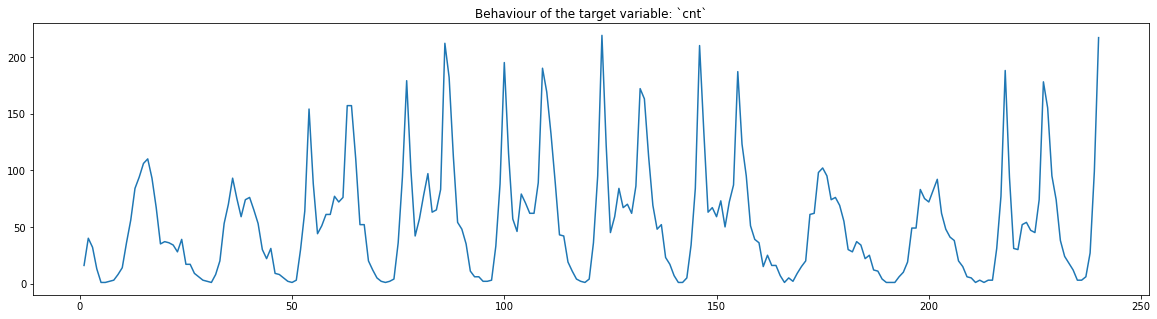

In [6]:
# first 10 days of the traget (24*5)
y = initial_hour_df.loc[:,'cnt'][0:240] 

# plotting
plt.figure(figsize=(20,5))
plt.title('Behaviour of the target variable: `cnt`')
plt.plot(y);

##### Does it follow a pattern? 
- Yes:
    - Time Series: it looks like it has a repeating pattern
- What sould we do about this?
    - choose a model that is good for predicting time series?      

### 1.2 Correlation, Distribution, Categorical Discussion

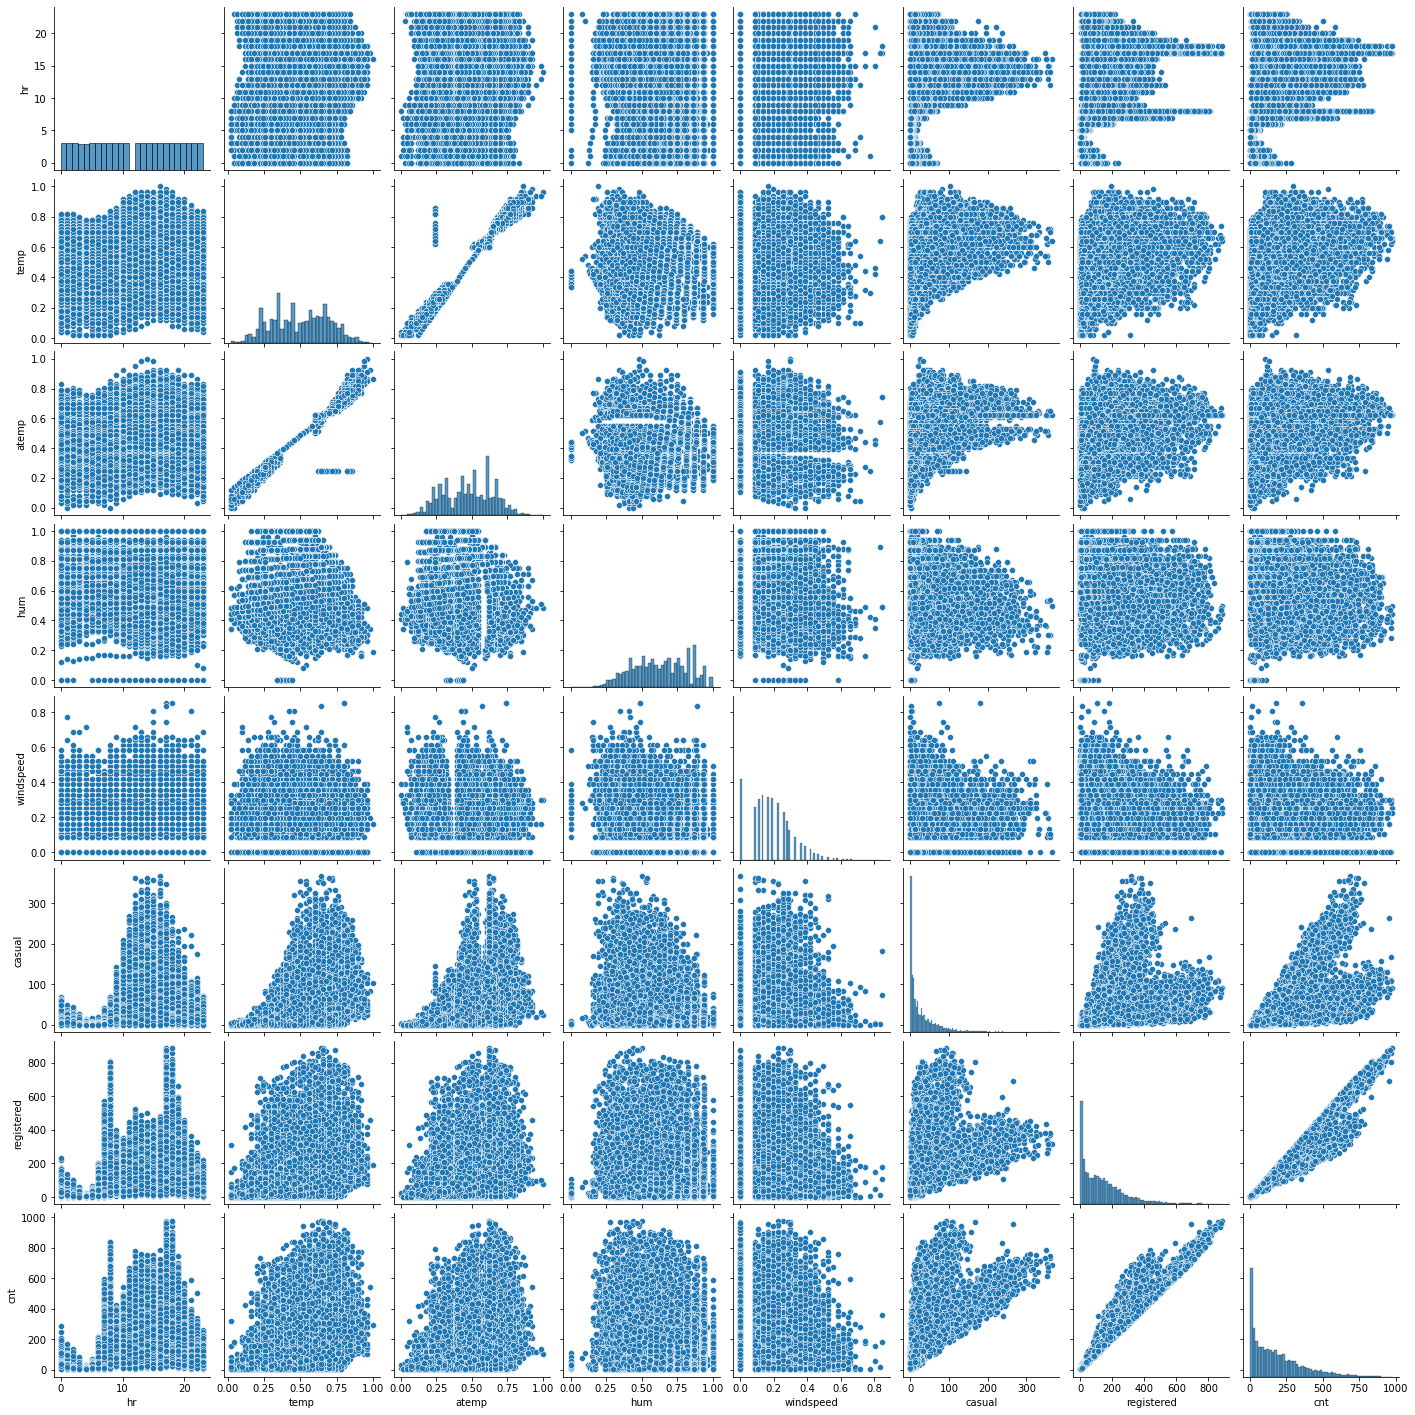

In [7]:
# plotting pairplot for hour_df
sns.pairplot(hour_df);

##### Are there any correlations?
- Yes: 
    - `temp` and `atemp` are higly correlated 
    - `registered` and `casual` are highly correlated to `cnt`  
- What sould we do about this?
    - dropping `registered` and `casual` is a good idea as it would mess with our prediction
    - dropping `temp` and `atemp` after a deeper analysis?

##### Are there any categorical variables?
- Yes: 
    - `weathersit` and `hr` are categorical
- What sould we do about this?
    - `weathersit` is also a string that needs to be converted in ordinal values

##### Is the data of all the varables normally distributed?
- No:
    - `windspeed` seems to be skewed
    - `windspeed` also seems to have many 0 and then a gap to the next values
        - maybe the measurement is not correct for low values, i.e. the sensor cant measure such low winds
- What sould we do about this? 
    - Maybe categorize windspeed in `very low`, `low`, `medium`, `high`, `very high`?


### 1.3 Missing Rows Discussion

##### Are there missing days?


In [8]:
# getting min/max date to find if there is a difference to real calendar in that range
min_date = hour_df.index.date.min()
max_date = hour_df.index.date.max()

no_of_missing_dates = len(list(pd.date_range(start = min_date, end = max_date).difference(hour_df.index.date)))
print(f"No of missing dates: {no_of_missing_dates}")

No of missing dates: 0


##### Are there missing rows for each day?

In [9]:
# grouping initial dataframe by dteday to find if there are days with missing rows
hour_count_df = initial_hour_df[['dteday','hr']].groupby(by="dteday").count()
print(f"Number of days with missing values for specific hours: {hour_count_df[hour_count_df.hr != 24].shape[0]}")

Number of days with missing values for specific hours: 76


- Yes: 
    - We have days with missing information. Not every Day has values/rows for 24 hours
- What should we do about this?
    - 0.4% missing -> 70/17000 -> ignore missing rows
    - if there were more missing you could add empty rows for the missing and interpolate the NANs

### 1.4 Missing Values Discussion

##### Are there missing values in hour_df?

In [10]:
# how many nans?
hour_df.isna().sum()

hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

- Yes: 
    - `weathersit`, `temp`, `atemp`, `hum`, and `windspeed` have missing values
- What should we do about this?
    - Impute missing

### 1.5 Outlier Discussion

##### Are there any variables with outliers?
 

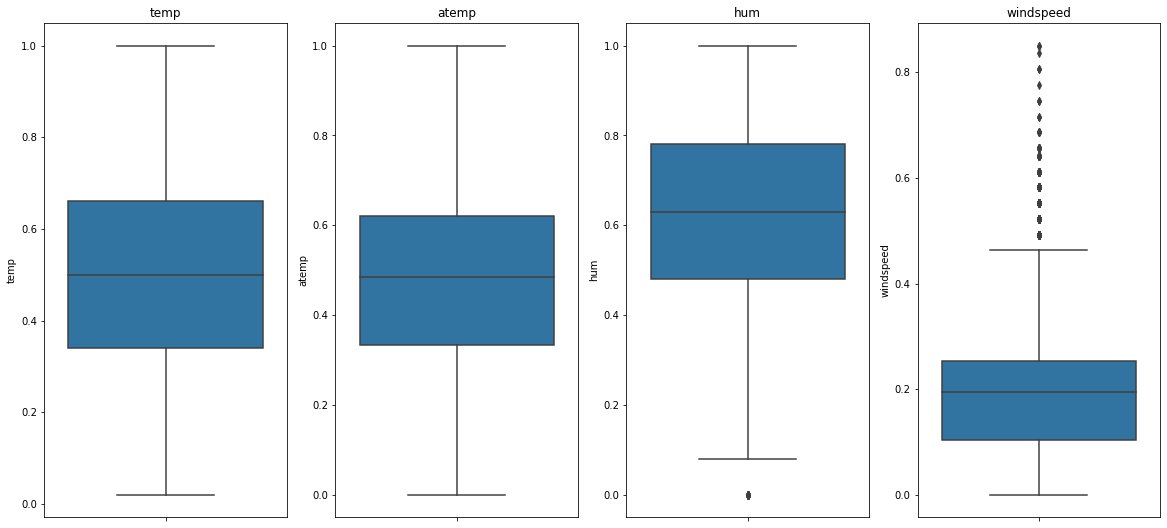

In [11]:
# continuous vatiables 
features = [
    'temp',
    'atemp',
    'hum',
    'windspeed',
]

# plotting boxplots
plt.figure(figsize=(20,20))

for i, col in enumerate(features):    
    plt.subplot(2,4,i + 1)
    plt.title(col)
    sns.boxplot(y=col, data=hour_df);

- Yes: 
    - `hum` and `windspeed`have outliers
- What sould we do about this:
    - Check if Outliers are realistic values, else:
        - Remove outliers? 
        - Fill with mean?
        - etc.

## Part 2: Data Engineering

### ToDo: 

1. Decide what to do and handle:
    - `missing rows`
    - `missing values`
    - `categorical variables`
    - `outliers`
    - `correlating variables`
    - `variables not normally distributed`
    - `categorical`

2. Generation of extra features:

### 2.1 Decide what to do and handle the... :
Creation of functions to call with our Function Transformer in our Pipeline

#####  Missing Rows (missing hours per day)
 - ignore as only 0.04% are missing 

##### Missing Values
- Linear Interpolation for missing values


In [12]:
def lin_interpolate(df):
    df= pd.DataFrame(df).interpolate(method="linear") # linear interpolation
    return df

##### Categorical Variables
- `hr` already ordinal
- `weathersit` needs to be converted into ordinal as well as the missing values filled

In [13]:
def ordinal_and_fillna_weathersit(df):
    df['weathersit'] = df.weathersit.astype("category").cat.codes # to ordinal
    df['weathersit'] = df.weathersit.fillna(method='backfill') # next valid observation to fill nan
    return df

##### Correlating Variables
-  checking correlation in detail with heatmap

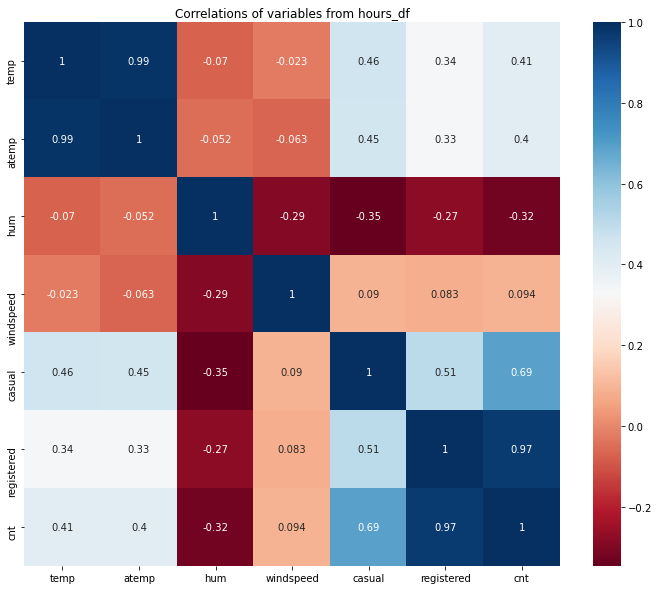

In [14]:
# plotting heatmap
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(hour_df.drop(['hr', 'weathersit'], axis = 1).corr(),cmap="RdBu", annot=True, ax=ax)
plt.title("Correlations of variables from hours_df");

Correlating Variables: `atemp`, `registered`, and `casual`
- Will drop correlating when splitting the dataset for ML in Part 3

##### Outlier Handling
- Creating functions to find outliers and plot the distributions

In [15]:
# finding outliers
def find_outliers(df, col):
    factor = 1.5
    
    df = df.copy()

    Q1 = np.nanpercentile(df[col], 25.)
    Q3 = np.nanpercentile(df[col], 75.)

    cut_off = (Q3 - Q1) * factor 
    upper, lower = Q3 + cut_off, Q1 - cut_off
    
    outlier_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
    outlier_list = df[col][(df[col] < lower) | (df[col] > upper)].tolist()

    return outlier_list, outlier_index

In [16]:
# function to show outlier distribution
def show_outlier_distribution(df, col):
    df = df.copy()

    outlier_list = find_outliers(df, col)[0]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.histplot(hour_df[col],bins = 51, ax=ax1)
    ax1.set_title('Whole Distribution')

    sns.histplot(outlier_list,bins = 51, ax=ax2)
    ax2.set_title('Outlier Distribution')
    plt.show()

- Check `weathersit` for the outliers and check if realistic

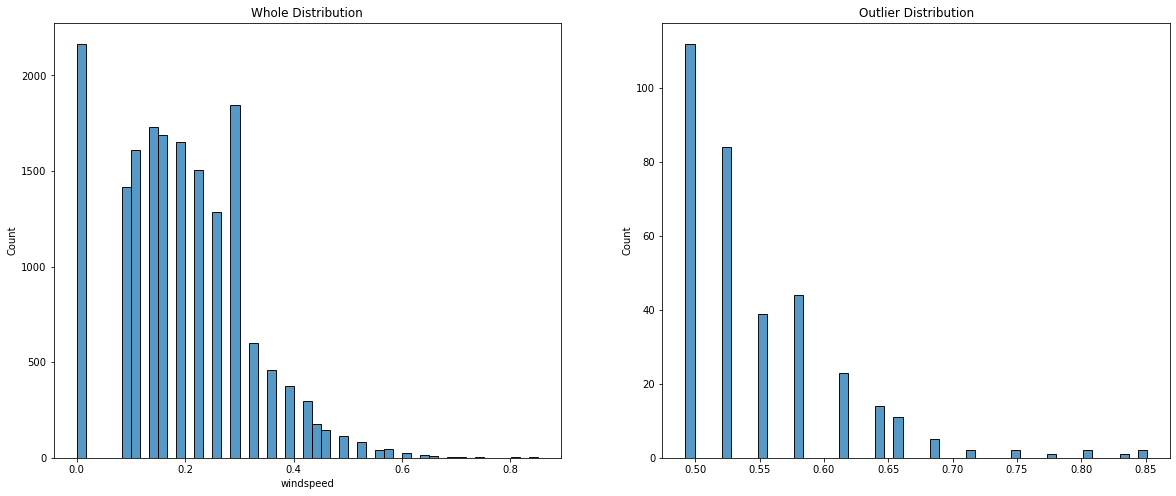

In [17]:
# check out the gap between zero and the next values, there must be an measurement error for low winds
show_outlier_distribution(hour_df, 'windspeed')

Findings:
- extreme winds are a normal phenomena in nature
    - going to keep those outliers and convert windspeed to categorical 
Handling:
- converting to categorical is also good as we have a gap from 0 to ~0.02 as sometimes there is no wind and the measurement is not exact
    - Going to do this directly in the pipeline with following functions

In [18]:
# Function to distcretize windspeed nto equal-sized buckets in pipeline
def distcretize_windspeed(df):
    df['windspeed'] =  pd.cut(df['windspeed'], bins=6, include_lowest= True).cat.codes
    return df

- Check `hum` for the outliers and check if normal?

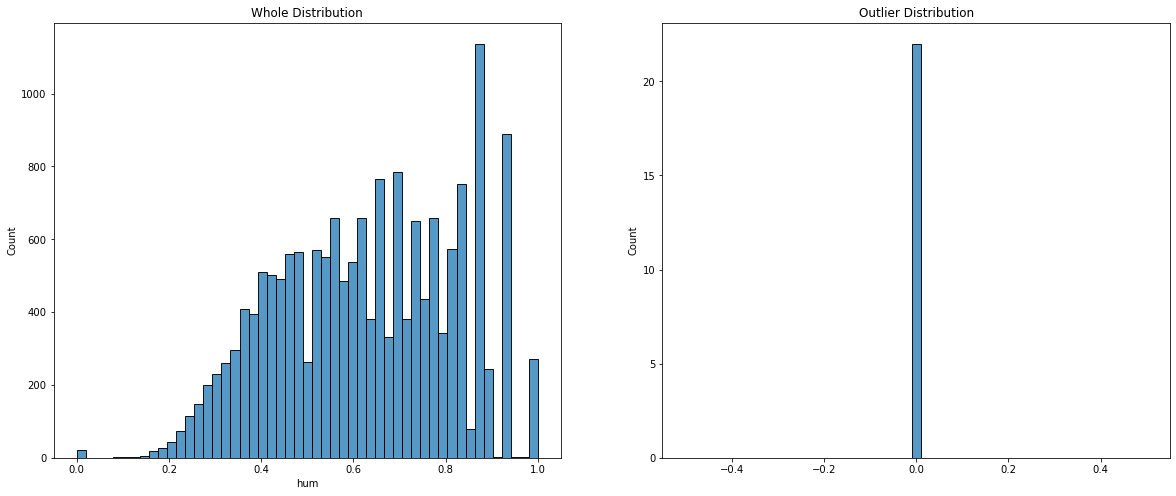

In [19]:
 # see how all outliers are zeros!
show_outlier_distribution(hour_df,'hum')

Findings:
- all outliers are zeros
- no humidity in that scale is not normal 

Handling:
- replacing those outliers with mean

In [20]:
# Function to fill `hum` outliers with mean in pipeline
def fill_outlier_with_mean(df):

    col = 'hum'
    
    outliers_index = find_outliers(df, col)[1]
     
    no_outliers = df['hum'].copy().drop(outliers_index,axis=0)
    
    mean = no_outliers.mean()
    
    #replacing outliers with mean
    df.loc[outliers_index,col] =  mean 

    return df

#### Variables not normally distributed
1. What to do?
    - add to preprocessor if done
    - from sklearn.preprocessing import  MinMaxScaler
    - hour_df['windspeed'] = MinMaxScaler().fit_transform(hour_df[['windspeed']]) # uusing extra pair of [] to create neccessary shape (x,x)
    - sns.distplot(hour_df['windspeed'])
    
    -  no need for random forest
    -  elso robust scaler
    
    We always prefer a normal distribution to skewed distribution. Here in boxlots also visible that they are skewed.

##### Preprocessor to handle functions for pipeline

- The preprocessor is a wrapper aroud a ColumnTransformer. This is neccessary as we want the Preprocessor to return a dataframe.
- We need a dataframe because after the preproccesing, we want to create new features within the pipeline. For those we need to access the column names.
- If we just use a ColumnTransformer, it returns a feature matrix without column names

In [21]:
class Preprocessor(ColumnTransformer):
    
    columns = ['weathersit','temp','hum','windspeed','hr']
    
    # using super() to use fit method of ColumnTransformer (the base class), but returning a dataframe instead
    def fit(self, X, y=None):
        return pd.DataFrame(super().fit(X), columns=self.columns, index=X.index)

    # same for the transform method
    def transform(self, X,y=None):
        return pd.DataFrame(super().transform(X), columns=self.columns, index=X.index)
    
    # needed for grid/pipeline to return pd.dataframe
    def fit_transform(self, X, y=None):
        #columns()
        return pd.DataFrame(super().fit_transform(X), columns=self.columns, index=X.index)

In [22]:
# Pipeline to transform `windspeed`
windspeed_pipe = Pipeline([
    (
        'fill_missing_values_with_linear_interpolation', FunctionTransformer(lin_interpolate), 
    ),(     
        "continuous_to_discrete", FunctionTransformer(distcretize_windspeed)
    )
])

In [23]:
# Pipeline to transform `hum`
hum_pipe = Pipeline([
    (
        'fill_missing_values_with_linear_interpolation', FunctionTransformer(lin_interpolate), 
    ),(     
        "fill_outlier_with_mean",FunctionTransformer(fill_outlier_with_mean)
    )
])

In [24]:
# ColumnTransformer to do handle all transformations
preprocessor = Preprocessor([
    (
        'ordinal_and_fillna_weathersit', FunctionTransformer(ordinal_and_fillna_weathersit), ['weathersit']
    ),(
        'fill_missing_values_with_linear_interpolation', FunctionTransformer(lin_interpolate), ['temp']
    ),(
        'fill_missing_values_and_drop_outliers_hum', hum_pipe, ['hum']
    ),(
        'fill_missing_values_and_transform_windspeed', windspeed_pipe, ['windspeed']
    )
],
    remainder = "passthrough"
)

### Part 2.2: Generation of extra features

    - Time 
        - dayofweek
        - quarter
        - month
        - season
        - year
        - dayofyear
        - dayofmonth
        - weekofyear
    - is_weekend
    - hours of daylight 
    

- Creating Time Features

In [25]:
def create_time_features(df):
    
    df['hr'] = df['hr'] 
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['season'] = (df['month']%12 + 3)//3
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.apply(lambda row: int(row.name.week), axis=1)
    
    return df

- Creating is_weekend Feature

In [26]:
def weekend(df):
    df['is_weekend'] = df.apply(lambda row: row.name.dayofweek > 4, axis=1)
    df['is_weekend'] = df['is_weekend'].astype("category").cat.codes # to ordinal
    return df

- Creating hours of daylight Feature
    - Transforming it to ordinal

In [27]:
def is_daylight(date, hour):
    
    city = 'Washington'
    date = date.strftime('%Y/%m/%d')
    sun = ephem.Sun()
    
    """
    ephem returns time in utc therefore - 5
    we have sunlight 30 min before sunrise and 30 min after sunset 
    therefore timedelta for sunrise - 5h 30m, for sunset - 4h 30m
    """
    sunrise = ephem.city(city).next_rising(sun, start=date).datetime() - timedelta(hours=5, minutes=30) 
    sunset = ephem.city(city).next_setting(sun, start=date).datetime() - timedelta(hours=4, minutes=30)

    return sunrise.hour <= hour <= sunset.hour

In [28]:
def daylight(df):
    df['daylight'] = df.apply(lambda row: is_daylight(row.name,row.hr), axis=1)
    df['daylight'] = df['daylight'].astype("category").cat.codes # to ordinal
    return df

##### Creating a FeatureCreator class to call on in the pipeline

In [29]:
class FeatureCreater(BaseEstimator, TransformerMixin):

    def fit(self,X,y = None): 
        return self
    
    def transform(self,X, y = None):
        # functions that create new features
        feature_creators = [create_time_features,weekend,daylight]

        for creator in feature_creators:
            X = creator(X) 
        return X  

    def fit_transform(self, X, y = None):
        # functions that create new features
        feature_creators = [create_time_features,weekend,daylight]

        for creator in feature_creators:
            X = creator(X)  
  
        return X  

## Part 3: Machine Learning

### 3.1 Splitting
- Splitting dataset according to task:
    - Training data: whole 2011 and first 3 quarters of 2012.
    - Test data: 4th quarter of 2012. Do not use it to fit your models!

In [30]:
split_date = '2012-06-30'

train = hour_df[hour_df.index  <= split_date] 
y_train = train['cnt']
X_train = train.drop(['casual','registered', 'cnt', 'atemp'], axis=1)


test = hour_df[hour_df.index  > split_date] 
y_test = test['cnt']
X_test = test.drop(['casual','registered', 'cnt', 'atemp'], axis=1)

### 3.2 ML Pipeline

##### Setting up the pipeline

In [31]:
pipe = Pipeline(steps=[
    (
    'preprocessor', preprocessor
    ),(
    'creating_new_custom_features', FeatureCreater()
    ),(
    'model', RandomForestRegressor(random_state=42) 
    )
])

### 3.3 Model Tuning

In [32]:
# first grid search
"""
original_param_grid = {
  'model__n_estimators': [50,100,200,300,500],
  'model__max_features': ['auto', 'sqrt', 'log2'],
  'model__max_depth': [2, 5,30, 45,100]
}


best_params ={
    'model__max_depth': 30,
    'model__max_features': 'auto',
    'model__n_estimators': 300
  }

r2_score = 0.856
"""

"\noriginal_param_grid = {\n  'model__n_estimators': [50,100,200,300,500],\n  'model__max_features': ['auto', 'sqrt', 'log2'],\n  'model__max_depth': [2, 5,30, 45,100]\n}\n\n\nbest_params ={\n    'model__max_depth': 30,\n    'model__max_features': 'auto',\n    'model__n_estimators': 300\n  }\n\nr2_score = 0.856\n"

In [33]:
# fine-tuning with knowlegde of first grid search
"""
second_param_grid = {
  'model__n_estimators': [250,300,350],
  'model__max_features': ['auto'],
  'model__max_depth': [25, 30, 35]
}

best_params ={
    'model__max_depth': 30,
    'model__max_features': 'auto',
    'model__n_estimators': 300
  }

r2_score = 0.856
"""

"\nsecond_param_grid = {\n  'model__n_estimators': [250,300,350],\n  'model__max_features': ['auto'],\n  'model__max_depth': [25, 30, 35]\n}\n\nbest_params ={\n    'model__max_depth': 30,\n    'model__max_features': 'auto',\n    'model__n_estimators': 300\n  }\n\nr2_score = 0.856\n"

In [34]:
# simplified grid with only `best_params` to be able to run whole skript without waiting a long time
param_grid = {
    'model__max_depth': [30],
    'model__max_features': ['auto'],
    'model__n_estimators': [300]
  }

In [35]:
# initialize grid
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='r2',
    cv=3,
    n_jobs=2, 
    verbose=2
)

In [36]:
# fit grid
grid.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Preprocessor(remainder='passthrough',
                                                     transformers=[('ordinal_and_fillna_weathersit',
                                                                    FunctionTransformer(func=<function ordinal_and_fillna_weathersit at 0x00000236BF0EDB80>),
                                                                    ['weathersit']),
                                                                   ('fill_missing_values_with_linear_interpolation',
                                                                    FunctionTransformer(func=<function lin_interpolate at 0x00...
                                                                                    ('continuous_to_discrete',
                                                                                     FunctionTransformer(func=<function distcretize_windspeed at 

In [37]:
# get best params from gridsearch
best_params = grid.best_params_
best_params

{'model__max_depth': 30,
 'model__max_features': 'auto',
 'model__n_estimators': 300}

### 3.4 Prediction with best model

In [38]:
# setting params for the last estimator in the pipeline (our model)
pipe.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 Preprocessor(remainder='passthrough',
                              transformers=[('ordinal_and_fillna_weathersit',
                                             FunctionTransformer(func=<function ordinal_and_fillna_weathersit at 0x00000236BF0EDB80>),
                                             ['weathersit']),
                                            ('fill_missing_values_with_linear_interpolation',
                                             FunctionTransformer(func=<function lin_interpolate at 0x00000236BF0ED9D0>),
                                             ['temp']),
                                            (...
                                             Pipeline(steps=[('fill_missing_values_with_linear_interpolation',
                                                              FunctionTransformer(func=<function lin_interpolate at 0x00000236BF0ED9D0>)),
                                                             ('cont

In [39]:
# Fitting pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Preprocessor(remainder='passthrough',
                              transformers=[('ordinal_and_fillna_weathersit',
                                             FunctionTransformer(func=<function ordinal_and_fillna_weathersit at 0x00000236BF0EDB80>),
                                             ['weathersit']),
                                            ('fill_missing_values_with_linear_interpolation',
                                             FunctionTransformer(func=<function lin_interpolate at 0x00000236BF0ED9D0>),
                                             ['temp']),
                                            (...
                                             Pipeline(steps=[('fill_missing_values_with_linear_interpolation',
                                                              FunctionTransformer(func=<function lin_interpolate at 0x00000236BF0ED9D0>)),
                                                             ('cont

In [40]:
# Predict training data
y_train_pred = pipe.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

print(f"R2 on training data: {r2_train}")

R2 on training data: 0.9920201791978004


In [41]:
# Predict test data
y_test_pred = pipe.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 on test data: {r2_test}")

R2 on test data: 0.856045114833056


### 3.5 Plotting predictions vs reality for additional insights

In [42]:
# widged slider to zoom into prediction vs reality plot
day_slider = widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=1,
    description='Days: ',
)
display(day_slider)

IntSlider(value=10, description='Days: ', max=20, min=2)

Text(0.5, 0, 'cumulative hours')

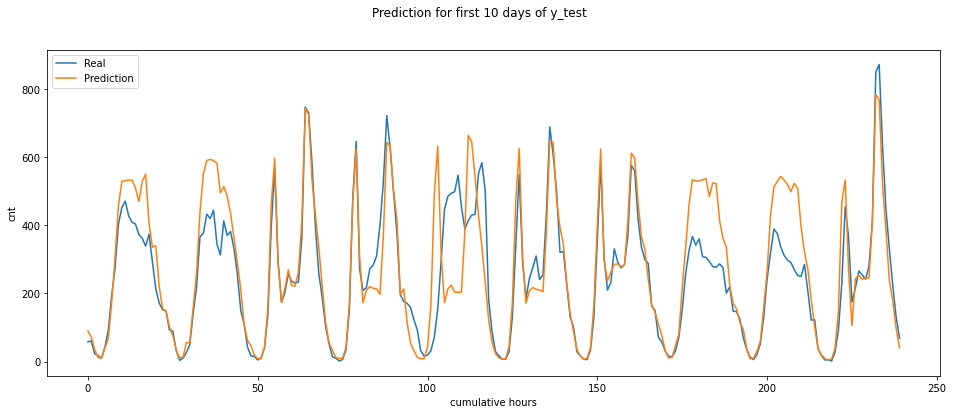

In [43]:
# using plt subplots combines with sns
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(f"Prediction for first {day_slider.value} days of y_test")


ax = sns.lineplot(data=list(y_test[0:(day_slider.value*24)]), label = 'Real')
ax1 = sns.lineplot(data=y_test_pred[0:(day_slider.value*24)],label = 'Prediction')

ax.set_ylabel('cnt')
ax.set_xlabel('cumulative hours')